In [8]:
import numpy as np
import scipy as sci
from src.plotting_func import plotting_defaults


ModuleNotFoundError: No module named 'src.plotting_func'

In [9]:
#import csv files and store it as numpy array
frame_rate = 62.6
delta_t = 1 / frame_rate




filename = "/home/aavash/Documents/Labs/tracking_files/best_green.csv"

data = np.genfromtxt(filename, delimiter=',', skip_header=1)
data[:,0] = data[:,0] * delta_t


In [10]:
def load_data(filename, multi_particle_index = 0):


    if filename.endswith("csv"):
        data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    else:
        from src.xml2csv import xml2csv
        #multi_particle_index used to determine what track to use if there are multiple (usually from the xaml file)
        a = xml2csv(filename, 2)

        data = a[multi_particle_index]

        data = np.array(data)

    return data


#calculate pearson correlation coefficent
import jax 
import jax.numpy as jnp
@jax.jit
def pearson_corr_coeff(pred, y):
    """
    Calculates pearson coeff.
    """
    pred = jnp.array(pred)
    y = jnp.array(y)    
    R = jnp.corrcoef(pred, y)[1, 0]
    
    return R

@jax.jit
def spearmen_corr_coeff(pred, y):
    
    rank_pred = jnp.argsort(jnp.argsort(pred))
    rank_y = jnp.argsort(jnp.argsort(y))
    val =  pearson_corr_coeff(rank_pred, rank_y)             
    
    return val


def msd_func(data, intervals=1, time_step=1, frame_rate=62.6, immersion=False):
    """
    Data = [b, ] 
    """
    intervals = np.arange(1, len(data))
    data_store = []
    time_step = 1 / frame_rate
    #calculate the intervals between points

    avg_square_dev = []
    std_square_dev = []
    time_interval = []
    if immersion:
        calibration_factor = 0.6*1e-3*0.1/979.3
    else:
        calibration_factor = (0.1*0.001)/1094.4

    data = data * calibration_factor

    for interval in intervals:
        data_store = []
        mean_square_deviation = []


        for i in range(0, len(data), interval):
            if i == 0:
                data_store.append(0)
                mean_square_deviation.append(0)

            else:
                
                data_store.append(data[i] - data[i-1])
                
                mean_square_deviation.append((data[i] - data[i-interval])**2)

        time_interval.append(time_step * interval)

        avg_square_dev.append(np.mean ( mean_square_deviation ))

        
        std_square_dev.append((np.std(mean_square_deviation))/(2 * np.sqrt( np.mean(mean_square_deviation))))
    
    return time_interval, avg_square_dev, std_square_dev

@jax.jit
def chi_squared(pred, y , pred_error):
    

    return jnp.sum((pred - y) **2 / pred_error**2)

In [11]:
data = load_data(filename="/home/aavash/Documents/Labs/tracking_files/cleaned_tracking/day3_vid2_Tracks0-3500.xml", multi_particle_index=5)


ModuleNotFoundError: No module named 'src.xml2csv'

In [6]:
data[:,0].shape

NameError: name 'data' is not defined

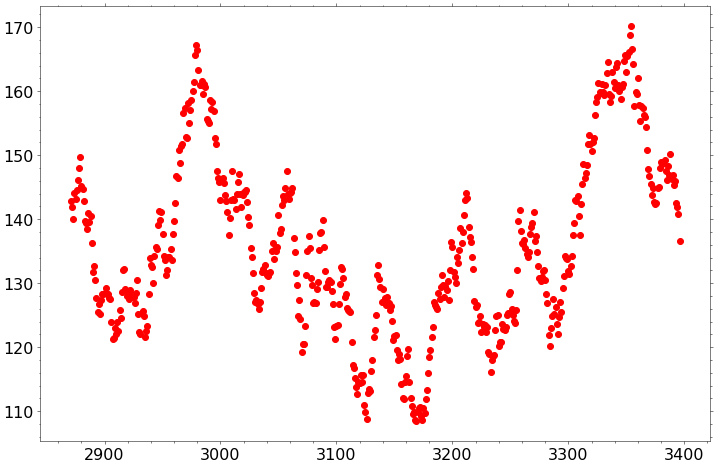

In [178]:
#plot the data
%matplotlib inline
plotting_defaults()
import matplotlib.pyplot as plt
plt.plot(data[:,0], data[:,1], 'ro')

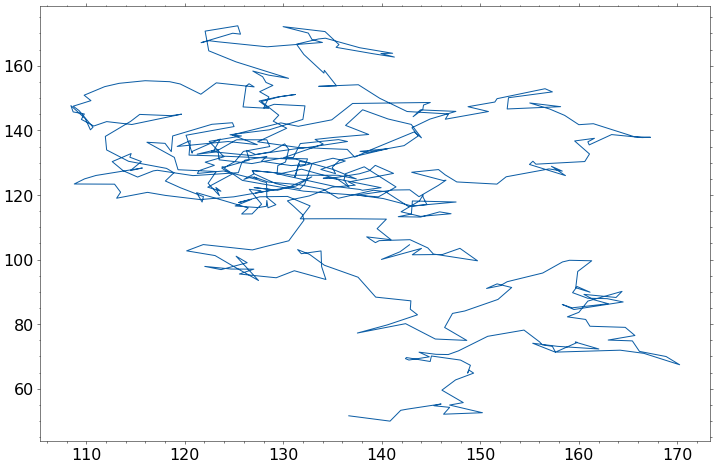

In [179]:
plt.plot(data[:,1], data[:,2])
#plt.line(data[:,1], data[:,2], 'bo')


In [180]:
x = data[:,1]
y = data[:,2]

In [181]:
x[0]

142.81181861044286

In [182]:
from hashlib import new
import matplotlib.animation as animation
from matplotlib import style
from matplotlib.animation import FuncAnimation
from random import randint


In [183]:
delta_val = x
intervals = np.arange(1, len(delta_val))
data_store = []
mean_square_deviation = []
time_step = 1
#calculate the intervals between points

avg_square_dev = []
std_square_dev = []
time_interval = []

for interval in intervals:
    data_store = []
    mean_square_deviation = []

    for i in range(0, len(delta_val), interval):
        if i == 0:
            data_store.append(0)
            mean_square_deviation.append(0)

        else:
            print
            data_store.append(delta_val[i] - delta_val[i-1])
            mean_square_deviation.append((delta_val[i] - delta_val[i-1])**2)
    time_interval.append(time_step *interval)
    avg_square_dev.append(np.sqrt(np.mean(mean_square_deviation)))
    std_square_dev.append(np.std(mean_square_deviation))



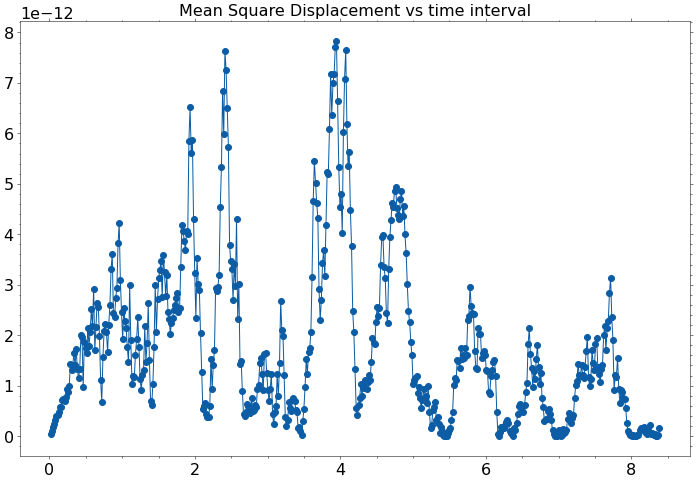

In [184]:
time_interval, avg_square_dev, std_square_dev = msd_func(x, immersion=False)
plotting_defaults()
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
plt.scatter(time_interval, avg_square_dev)
plt.plot(time_interval, avg_square_dev)

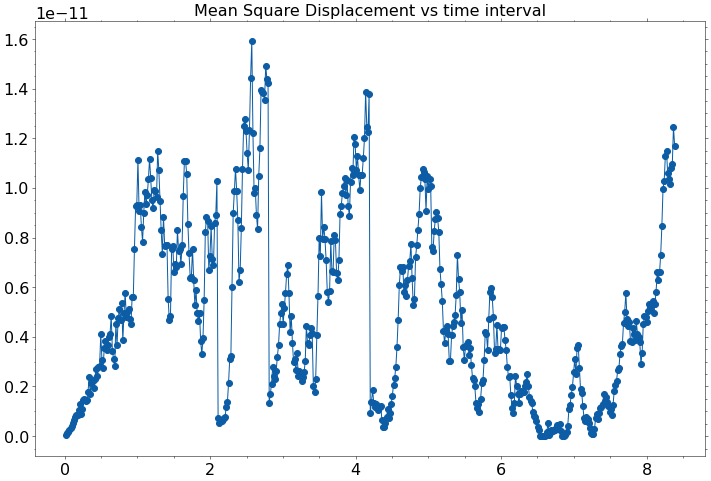

In [185]:
time_interval, avg_square_dev, std_square_dev = msd_func(y, immersion=False)
plotting_defaults()
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
plt.scatter(time_interval, avg_square_dev)
plt.plot(time_interval, avg_square_dev)

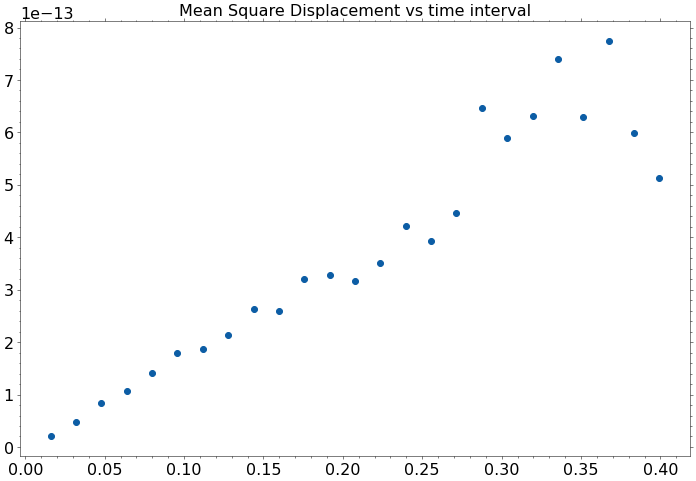

In [186]:
time_interval, avg_square_dev, std_square_dev = msd_func(x, immersion=True)
plotting_defaults()

temp_time_interval = time_interval[:25]
temp_square = avg_square_dev[:25]
temp_dev = std_square_dev[:25]
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
plt.scatter(temp_time_interval, temp_square)




D = kT / 6 \pi  \nu r

on

In [187]:
def visc_calc(gradient, diameter, temperature=291):

    from scipy.constants import Boltzmann as k
    
    eta = (4 * k * temperature) / (3 * np.pi * gradient * diameter)
    return eta


In [188]:
#fit a linear function to the data
from scipy.optimize import curve_fit
#import boltzmann constant
def func(x, a, b):
    return a * x + b



popt, pcov = curve_fit(func, temp_time_interval, temp_square, sigma=temp_dev)
eta = visc_calc(popt[0], diameter=0.5e-6)
delta_eta = eta * np.sqrt((pcov[0][0] / popt[0] ** 2) + (0.05/291) ** 2)

print(f"The viscosity is {eta:.4f} +/- {delta_eta:.4f} Pa.s")


The viscosity is 0.0019 +/- 0.0001 Pa.s


In [189]:
popt[0] = float(popt[0])
popt[1] = float(popt[1])

In [190]:
np.sqrt(pcov)

/tmp/ipykernel_5910/3743271416.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(pcov)


array([[8.91251444e-14,            nan],
       [           nan, 1.58920223e-14]])

In [191]:
float(popt[0])

1.7979373197855366e-12

In [192]:
updated_lines = []
updated_lines_1 = []
updated_lines_2 = []
for times in temp_time_interval:
    updated_lines.append(func(times, popt[0], popt[1]))
    updated_lines_1.append(func(times, popt[0] + np.sqrt(pcov[0][0]), popt[1] - np.sqrt(pcov[1][1])))
    updated_lines_2.append(func(times, popt[0] - np.sqrt(pcov[0][0]), popt[1] + np.sqrt(pcov[1][1])))

In [193]:
print(spearmen_corr_coeff(np.array(temp_square), np.array(updated_lines)))
print(pearson_corr_coeff(temp_square, updated_lines))
print(chi_squared(np.array(temp_square), np.array(updated_lines), np.array(temp_dev)))

0.9546154
0.9499893
9.689903e-13


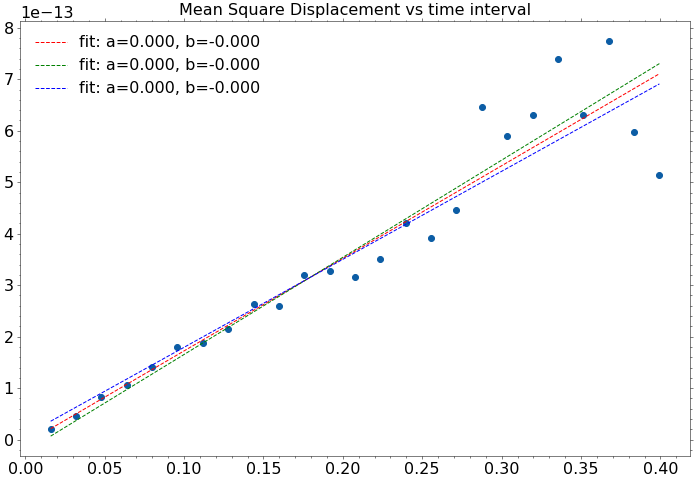

In [194]:
%matplotlib ipympl

plt.title("Mean Square Displacement vs time interval")
plt.scatter(temp_time_interval, temp_square)

plt.plot(temp_time_interval, updated_lines, 'r--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(temp_time_interval, updated_lines_1, 'g--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(temp_time_interval, updated_lines_2, 'b--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.legend()

In [195]:
#reduced chi squared calculation
reduced_chi_squared = np.sum((np.array(temp_square) - np.array(updated_lines))**2 / np.array(updated_lines)) / (len(temp_square) - 1)
reduced_chi_squared

8.261122588411367e-15

In [196]:
popt

array([ 1.79793732e-12, -7.37991006e-15])

<ErrorbarContainer object of 3 artists>

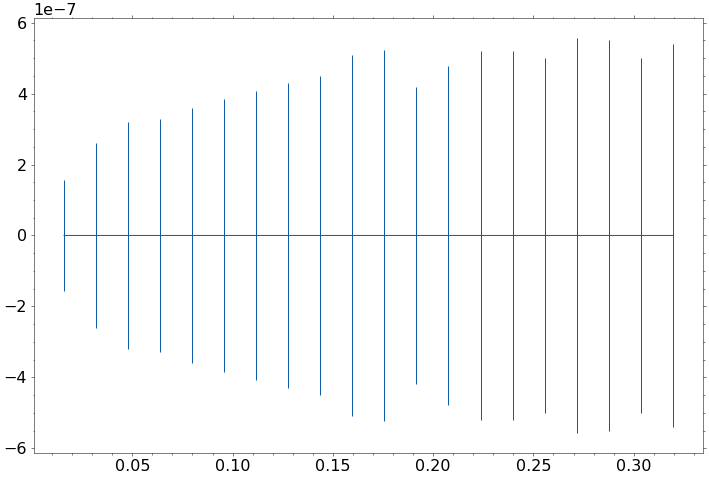

In [197]:
time_interval, avg_square_dev, std_square_dev = msd_func(x)
%matplotlib ipympl
plt.errorbar(time_interval[:20], avg_square_dev[:20], yerr=std_square_dev[:20])

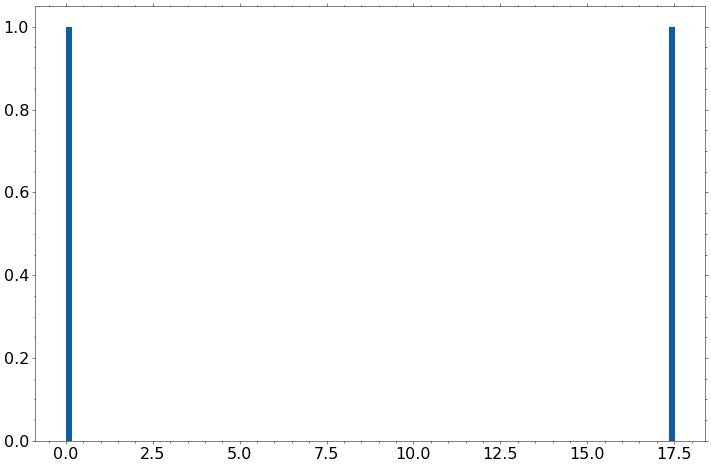

In [198]:

%matplotlib ipympl
plt.hist(mean_square_deviation, bins=100);


In [2]:
import random
import matplotlib
from matplotlib import animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import count
%matplotlib qt

/home/aavash/anaconda3/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /usr/lib/x86_64-linux-gnu/gio/modules/libgiolibproxy.so


In [1]:
temp_x, temp_y = [], []
fig = plt.figure(figsize=(12,8))
axes = fig.add_subplot(1,1,1)

def animate(i):
    temp_x.append(x[i])
    temp_y.append(y[i])
    plt.plot(x,y, scaley=True, scalex=True, color="blue")
anim = FuncAnimation(fig, animate, interval=200)


NameError: name 'plt' is not defined